# Compute potential intensity for climate models

```
conda create -n potint -y netcdf4 xarray=0.16.2 numpy numba ipykernel                           # don't add matplotlib after xarray - broke installation
conda activate potint
pip install tcpypi
```

# Sample run to check installation

In [ ]:
# This pyPI script computes PI and associated analyses over the entire sample dataset
# which is from 2004, MERRA2.
#
# Created by Daniel Gilford, PhD (daniel.gilford@rutgers.edu)
# Many thanks to Daniel Rothenberg for his assitance optimizing pyPI
#
# Last updated 8/14/2020
#

# setup
import xarray as xr
import pickle

# load in pyPI modules
from tcpyPI import pi
from tcpyPI.utilities import *

# define the sample data locations
datdir='./data/'
_FN=datdir+'sample_data.nc'
_mdrF=datdir+'mdr.pk1' 
    

def run_sample_dataset(fn, dim='p',CKCD=0.9):
    """ This function calculates PI over the sample dataset using xarray """
    
    # open the sample data file
    ds = xr.open_dataset(fn)
    # calculate PI over the whole data set using the xarray universal function
    result = xr.apply_ufunc(
        pi,
        ds['sst'], ds['msl'], ds['p'], ds['t'], ds['q'],
        kwargs=dict(CKCD=CKCD, ascent_flag=0, diss_flag=1, ptop=50, miss_handle=1),
        input_core_dims=[
            [], [], ['p', ], ['p', ], ['p', ],
        ],
        output_core_dims=[
            [], [], [], [], []
        ],
        vectorize=True
    )

    # store the result in an xarray data structure
    vmax, pmin, ifl, t0, otl = result
    out_ds=xr.Dataset({
        'vmax': vmax, 
        'pmin': pmin,
        'ifl': ifl,
        't0': t0,
        'otl': otl,
        # merge the state data into the same data structure
        'sst': ds.sst,
        't': ds.t,
        'q': ds.q,
        'msl': ds.msl,
        'lsm': ds.lsm,
        })
    
    # add names and units to the structure
    out_ds.vmax.attrs['standard_name'],out_ds.vmax.attrs['units']='Maximum Potential Intensity','m/s'
    out_ds.pmin.attrs['standard_name'],out_ds.pmin.attrs['units']='Minimum Central Pressure','hPa'
    out_ds.ifl.attrs['standard_name']='pyPI Flag'
    out_ds.t0.attrs['standard_name'],out_ds.t0.attrs['units']='Outflow Temperature','K'
    out_ds.otl.attrs['standard_name'],out_ds.otl.attrs['units']='Outflow Temperature Level','hPa'

    # return the output from pi.py as an xarray data structure
    return out_ds

def run_sample_analyses(ds,_mdrF,CKCD=0.9):
    """ This function performs PI analyses over the sample dataset using xarray """

    # load the basins dictionary
    basins = pickle.load( open( _mdrF, "rb" ) )
    
    # calculate PI analyses over the whole data set using the xarray universal function
    efficiency = xr.apply_ufunc(
        pi_efficiency,
        ds['sst']+273.15, ds['t0'],
        input_core_dims=[
            [], [],
        ],
        output_core_dims=[
            [],
        ],
        vectorize=True
    )
    
    diseq = xr.apply_ufunc(
        pi_diseq_resid,
        ds['vmax'], ds['sst']+273.15, ds['t0'],
        kwargs=dict(CKCD=CKCD),
        input_core_dims=[
            [], [], [],
        ],
        output_core_dims=[
            [],
        ],
        vectorize=True
    )
    
    result = xr.apply_ufunc(
        decompose_pi,
        ds['vmax'], ds['sst']+273.15, ds['t0'],
        kwargs=dict(CKCD=CKCD),
        input_core_dims=[
            [], [], [],
        ],
        output_core_dims=[
            [], [], [], [],
        ],
        vectorize=True
    )

    lnpi, lneff, lndiseq, lnCKCD = result
    
    out_ds = xr.Dataset({
                'eff': efficiency, 
                'diseq': diseq,
                'lnpi': lnpi,
                'lneff': lneff,
                'lndiseq': lndiseq,
                'lnCKCD': lnCKCD[0,0,0]
            })
    
    # add names and units (where applicable)
    out_ds.eff.attrs['standard_name'],out_ds.eff.attrs['units']='Tropical Cyclone Efficiency','unitless fraction'
    out_ds.diseq.attrs['standard_name'],out_ds.diseq.attrs['units']='Thermodynamic Disequilibrium','J/kg'
    out_ds.lnpi.attrs['standard_name']='Natural log(Potential Intensity)'
    out_ds.lneff.attrs['standard_name']='Natural log(Tropical Cyclone Efficiency)'
    out_ds.lndiseq.attrs['standard_name']='Natural log(Thermodynamic Disequilibrium)'
    out_ds.lnCKCD.attrs['standard_name'],out_ds.lnCKCD.attrs['units']='Natural log(Ck/CD)','unitless constant'

    # return the output from pi.py as an xarray data structure
    return out_ds
    
    

if __name__ == "__main__":

    # Execute PI analysis over the whole dataset and save the output
    print('Beginning PI computations...')
    ds = run_sample_dataset(_FN)
    ds.to_netcdf(datdir+'raw_sample_output.nc')
    print('...PI computation complete and saved\n')
    
    # Perform PI analyses over the whole dataset
    print('Performing PI analyses...')
    ds2 = run_sample_analyses(ds,_mdrF,CKCD=0.9)
    
    # merge the arrays and save the output
    ds3=ds.merge(ds2)
    ds3.to_netcdf(datdir+'full_sample_output.nc')
    del ds, ds2
    print('...PI analyses complete and saved')
    print('pyPI sample run finished!')

# Potential intensity for a climate model

In [55]:
import glob, re
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", message = ".+C_CONTIGUOUS.+")
import xarray as xr
import xesmf as xe
import numpy as np

import matplotlib.pyplot as plt

In [15]:
mdl = "CMCC-ESM2"

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/"
outpath = "/rds/general/user/cb2714/home/99_ephemera/cmip6_"

## Regrid tos from unstructured to structured grid

Using xesmf: https://pavics-sdi.readthedocs.io/en/latest/notebooks/regridding.html


In [3]:
# file with target lat-lon grid
lsm = xr.open_dataset("data/sftlf_fx_CMCC-ESM2_historical_r1i1p1f1_gn.nc")

In [ ]:
tos = convert_units_to(xr.open_mfdataset(fpath+mdl+"/tos/*.nc"), "degC")

# add CF attributes to allow regridding
tos.i.attrs['axis'] = 'X'
tos.j.attrs['axis'] = 'Y'

# regrid SSTs to regular land-sea mask grid
rg = xe.Regridder(tos, lsm, "bilinear", ignore_degenerate = True)
tos_rg = rg(tos).tos.assign_attrs(units = "degC")

# save individual files per decade
for y in range(1850,2060,10):
    tos_rg.sel(time = slice(str(y),str(y+9))).to_netcdf(outpath+"tos/tos-rg-with-gaps_"+mdl+"_"+str(y)+"-"+str(y+9)+".nc")

In [58]:
for fnm in glob.glob(outpath+"tos/tos-rg-with-gaps_"+mdl+"*.nc"):
    ds = xr.open_dataset(fnm).tos.assign_attrs(units = "degC")
    
    # check for missing values & interpolate
    if any(ds.sum(["lat", "time"]) == 0):
        empty_col = (ds.sum(["lat", "time"]) == 0).argmax().values
        ds[:,:,empty_col] = ds.isel(lon = slice(empty_col-1, empty_col+2)).mean("lon").transpose("time", "lat")
        
    ds.to_netcdf(re.sub("-with-gaps","",fnm))

## Compile other variables

In [59]:
import sys; sys.path.append('..'); from wwa import *

fpath = "/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/"
outpath = "/rds/general/user/cb2714/home/99_ephemera/cmip6_"

In [60]:
mdl = "CMCC-ESM2"

In [ ]:
hus = convert_units_to(xr.open_mfdataset(fpath+mdl+"/hus/*.nc").hus, "g/kg")
hus["plev"] = convert_units_to(hus.plev, "hPa")
for y in range(1850,2060,10):
    hus.sel(time = slice(str(y),str(y+9))).to_netcdf(outpath+"hus/hus_"+mdl+"_"+str(y)+"-"+str(y+9)+".nc")

In [ ]:
ta = convert_units_to(xr.open_mfdataset(fpath+mdl+"/ta/*.nc").ta, "degC")
ta["plev"] = convert_units_to(ta.plev, "hPa")
for y in range(1850,2060,10):
    ta.sel(time = slice(str(y),str(y+9))).to_netcdf(outpath+"ta/ta_"+mdl+"_"+str(y)+"-"+str(y+9)+".nc")

In [ ]:
psl = convert_units_to(xr.open_mfdataset(fpath+mdl+"/psl/*.nc").ta, "degC")
for y in range(1850,2060,10):
    psl.sel(time = slice(str(y),str(y+9))).to_netcdf(outpath+"psl/psl_"+mdl+"_"+str(y)+"-"+str(y+9)+".nc")

In [ ]:
lf = xr.open_dataset("data/sftlf_fx_CMCC-ESM2_historical_r1i1p1f1_gn.nc").sftlf
lsm = xr.ones_like(lf).where(lf >= 0.5, 0).rename("lsm")
ldm.to_netcdf("/rds/general/user/cb2714/home/99_ephemera/")

## Compute PI from gridded data

In [2]:
test_ds = xr.open_dataset("data/sample_data.nc")

In [3]:
# load each variable for a single year
hus = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/CMCC-ESM2/hus/hus_day_CMCC-ESM2_historical_r1i1p1f1_gn_18500101-18511231.nc").sel(time = "1850").hus
ta = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/CMCC-ESM2/ta/ta_day_CMCC-ESM2_historical_r1i1p1f1_gn_18500101-18511231.nc").sel(time = "1850").ta
psl = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/CMCC-ESM2/psl/psl_day_CMCC-ESM2_historical_r1i1p1f1_gn_18500101-18741231.nc").sel(time = "1850").psl
tos = xr.open_dataset("data/tos-regridded.nc").tos

lf = xr.open_dataset("data/sftlf_fx_CMCC-ESM2_historical_r1i1p1f1_gn.nc").sftlf
lsm = xr.ones_like(lf).where(lf >= 0.5, 0).rename("lsm")

In [6]:
ds = wrap_lon(xr.merge([lsm, tos, psl, ta, hus]).rename(plev = "p", ta = "t", hus = "q", psl = "msl", tos = "sst"))

In [8]:
ds["p"] = convert_units_to(ds.p, "hPa")
ds["sst"] = ds["sst"].assign_attrs(units = "degC")
ds["t"] = convert_units_to(ds.t, "degC")
ds["q"] = convert_units_to(ds.q, "g/kg")

In [10]:
ds.to_netcdf("CMCC-ESM2_1850_vars.nc")

### Compute potential intensity

In [1]:
import xarray as xr
import warnings; warnings.filterwarnings("ignore", category = FutureWarning)

from tcpyPI import pi
from tcpyPI.utilities import *

In [3]:
# load each variable for a single year
hus = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/CMCC-ESM2/hus/hus_day_CMCC-ESM2_historical_r1i1p1f1_gn_18500101-18511231.nc").hus
ta = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/CMCC-ESM2/ta/ta_day_CMCC-ESM2_historical_r1i1p1f1_gn_18500101-18511231.nc").sel(time = "1850").ta
psl = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/synda_clair/data/CMIP6/CMCC-ESM2/psl/psl_day_CMCC-ESM2_historical_r1i1p1f1_gn_18500101-18741231.nc").sel(time = "1850").psl
tos = xr.open_dataset("data/tos-regridded.nc").tos

lf = xr.open_dataset("data/sftlf_fx_CMCC-ESM2_historical_r1i1p1f1_gn.nc").sftlf
lsm = xr.ones_like(lf).where(lf >= 0.5, 0).rename("lsm")

In [7]:
ds = xr.open_dataset("CMCC-ESM2_1850_vars.nc")

In [8]:
result = xr.apply_ufunc(
    pi,
    ds['sst'], ds['msl'], ds['p'], ds['t'], ds['q'],
    kwargs=dict(CKCD=0.9, ascent_flag=0, diss_flag=1, ptop=50, miss_handle=1),
    input_core_dims=[
        [], [], ['p', ], ['p', ], ['p', ],
    ],
    output_core_dims=[
        [], [], [], [], []
    ],
    vectorize=True
)

In [5]:
# store the result in an xarray data structure
vmax, pmin, ifl, t0, otl = result
out_ds=xr.Dataset({
    'vmax': vmax, 
    'pmin': pmin,
    'ifl': ifl,
    't0': t0,
    'otl': otl,
    })

In [6]:
out_ds.to_netcdf("PI.nc")

### Plot output

In [1]:
import sys; sys.path.append('..'); from wwa import *

In [2]:
ds = xr.open_dataset("PI.nc")

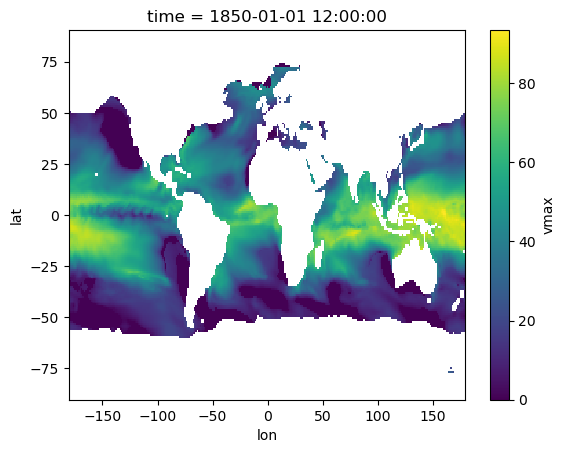

In [4]:
ds.isel(time = 0).vmax.plot()

In [9]:
import xesmf

ModuleNotFoundError: No module named 'xesmf'

In [7]:
(hus * 1000).max()

<xarray.DataArray 'hus' ()>
array(27.623001, dtype=float32)